In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import resnet

import time
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# torch.cuda.is_available()

True

In [ ]:
# print(device)

cuda


In [ ]:
# print(torch.__version__)

1.9.0+cu111


In [ ]:
# !pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.1.0
addict                        2.4.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.3.1
anaconda-client               1.9.0
anaconda-navigator            2.1.4
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
asgiref                       3.6.0
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-generator               1.10
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backca

In [ ]:
# !pip install torch==1.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu111/torch-1.9.0%2Bcu111-cp39-cp39-win_amd64.whl (3128.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0


In [ ]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
train_transform = A.Compose(
    [
        A.RandomCrop(height=224, width=224),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ]),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
val_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join('C:/Users/ghtyu/Kyeong6/contest_data',self.data.iloc[idx, 1])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
dataset = SatelliteDataset(csv_file='C:/Users/ghtyu/Kyeong6/contest_data/train.csv', transform=None)

In [ ]:
from torch.utils.data import random_split

# train data와 validation data를 나눌 비율 설정
train_ratio = 0.8
val_ratio = 0.2

# 데이터셋을 나누기 위한 길이 계산
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# 데이터셋을 나누기 전에 transform을 적용하여 train_dataset과 val_dataset 생성
train_dataset = SatelliteDataset(csv_file='C:/Users/ghtyu/Kyeong6/contest_data/train.csv', transform=train_transform)
val_dataset = SatelliteDataset(csv_file='C:/Users/ghtyu/Kyeong6/contest_data/train.csv', transform=val_transform)

# 데이터셋을 나누기 위해 random_split 함수 사용
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 각 데이터셋을 DataLoader로 변환
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
# U-Net++ 모델 정의
class UNetPlusPlusModel(nn.Module):
    def __init__(self, num_classes):
        super(UNetPlusPlusModel, self).__init__()
        self.model = smp.UnetPlusPlus(encoder_name='resnet34',
                                      encoder_depth=5,
                                      encoder_weights='imagenet',
                                      decoder_use_batchnorm=True,
                                      decoder_channels=(256, 128, 64, 32, 16),
                                      decoder_attention_type=None, in_channels=3,
                                      classes=1,
                                      activation=None,
                                      aux_params=None)

    def forward(self, x):
        return self.model(x)

# DeepLabV3+ 모델 정의
class DeepLabV3PlusModel(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3PlusModel, self).__init__()
        self.model = smp.DeepLabV3Plus(encoder_name='resnet34',
                                       encoder_depth=5,
                                       encoder_weights='imagenet',
                                       encoder_output_stride=16,
                                       decoder_channels=256,
                                       decoder_atrous_rates=(12, 24, 36),
                                       in_channels=3,
                                       classes=1,
                                       activation=None,
                                       upsampling=4,
                                       aux_params=None)

    def forward(self, x):
        return self.model(x)

# U-Net과 DeepLabV3+를 Ensemble한 모델 정의
class EnsembleModel(nn.Module):
    def __init__(self, num_classes, weights=[0.5, 0.5]):
        super(EnsembleModel, self).__init__()
        self.unet = UNetPlusPlusModel(num_classes)
        self.deeplab = DeepLabV3PlusModel(num_classes)
        self.weights = weights

    def forward(self, x):
        unet_output = self.unet(x)
        deeplab_output = self.deeplab(x)
        # Ensemble 방법: 각 모델의 출력을 가중치(weights)를 고려하여 합산
        output = self.weights[0] * unet_output + self.weights[1] * deeplab_output
        return output

In [ ]:
# BCE + Dice Loss
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# seed 고정
seed = 42
seed_everything(seed)

In [ ]:
epochs = 40
lr = 0.001
batch_size = 16
reg = 1e-4

In [ ]:
num_classes = 1
model = EnsembleModel(num_classes=num_classes).to(device)

criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=reg)

In [ ]:
# 학습 함수
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0

    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(dataloader)

    return train_loss

# 검증 함수
def validate(model, dataloader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))

            val_loss += loss.item()

    val_loss /= len(dataloader)

    return val_loss

In [ ]:
# 학습과정에서 손실 및 정확도 기록용 리스트
train_losses = []
val_losses = []

In [ ]:
# 학습 루프
for epoch in range(epochs):
    # 훈련 단계
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 검증 단계
    val_loss = validate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

  0%|                                                                                          | 0/357 [00:00<?, ?it/s]C:\Users\ghtyu\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\ghtyu\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:40<00:00,  2.22it/s]


Epoch 1: Train Loss: 0.6621, Val Loss: 0.6022


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.31it/s]


Epoch 2: Train Loss: 0.5698, Val Loss: 0.6890


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 3: Train Loss: 0.5295, Val Loss: 0.5629


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 4: Train Loss: 0.5127, Val Loss: 0.5210


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 5: Train Loss: 0.4960, Val Loss: 0.5189


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 6: Train Loss: 0.4921, Val Loss: 0.4586


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 7: Train Loss: 0.4793, Val Loss: 0.5161


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 8: Train Loss: 0.4769, Val Loss: 0.4700


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 9: Train Loss: 0.4796, Val Loss: 0.5002


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 10: Train Loss: 0.4690, Val Loss: 0.4732


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 11: Train Loss: 0.4650, Val Loss: 0.4552


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 12: Train Loss: 0.4485, Val Loss: 0.4442


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 13: Train Loss: 0.4515, Val Loss: 0.4571


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 14: Train Loss: 0.4594, Val Loss: 0.4945


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 15: Train Loss: 0.4401, Val Loss: 0.4453


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 16: Train Loss: 0.4470, Val Loss: 0.4482


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 17: Train Loss: 0.4393, Val Loss: 0.4598


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 18: Train Loss: 0.4520, Val Loss: 0.5645


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 19: Train Loss: 0.4440, Val Loss: 0.4912


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 20: Train Loss: 0.4198, Val Loss: 0.4236


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 21: Train Loss: 0.4409, Val Loss: 0.4508


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 22: Train Loss: 0.4378, Val Loss: 0.4281


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 23: Train Loss: 0.4243, Val Loss: 0.4461


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 24: Train Loss: 0.4250, Val Loss: 0.4020


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 25: Train Loss: 0.4377, Val Loss: 0.4435


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 26: Train Loss: 0.4436, Val Loss: 0.3957


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 27: Train Loss: 0.4209, Val Loss: 0.4416


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 28: Train Loss: 0.4364, Val Loss: 0.4125


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 29: Train Loss: 0.4138, Val Loss: 0.4155


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.30it/s]


Epoch 30: Train Loss: 0.4183, Val Loss: 0.4129


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 31: Train Loss: 0.4159, Val Loss: 0.4287


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.27it/s]


Epoch 32: Train Loss: 0.4293, Val Loss: 0.4606


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 33: Train Loss: 0.4071, Val Loss: 0.4660


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 34: Train Loss: 0.4165, Val Loss: 0.4261


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 35: Train Loss: 0.4071, Val Loss: 0.4178


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 36: Train Loss: 0.4265, Val Loss: 0.3998


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 37: Train Loss: 0.4242, Val Loss: 0.4707


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]


Epoch 38: Train Loss: 0.4098, Val Loss: 0.4016


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.28it/s]


Epoch 39: Train Loss: 0.4075, Val Loss: 0.5003


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:39<00:00,  2.29it/s]

Epoch 40: Train Loss: 0.4183, Val Loss: 0.6283


In [ ]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))

    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

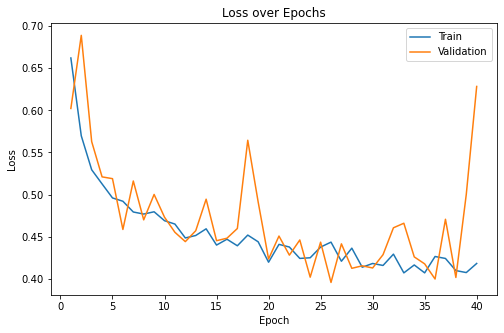

In [ ]:
# 손실 그래프만 표시
plot_loss(train_losses, val_losses)

In [ ]:
test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [ ]:
test_dataset = SatelliteDataset(csv_file='C:/Users/ghtyu/Kyeong6/contest_data/test.csv', transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████████████████████████████████████████████████████████████████████████| 3790/3790 [06:48<00:00,  9.28it/s]


In [ ]:
submit = pd.read_csv('C:/Users/ghtyu/Kyeong6/contest_data/sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('C:/Users/ghtyu/Kyeong6/k_submit_0721.csv', index=False)